In [2]:
import jax
import flax
import optax
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from jax import random, numpy as jnp

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=42)
obs, info

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

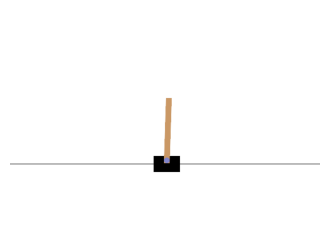

In [3]:
def show_env(env):
    img = env.render()
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')

show_env(env)

In [4]:
action=1
obs,reward,done,truncated,info = env.step(action)
obs, reward, done, truncated

(array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32),
 1.0,
 False,
 False)

In [5]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)

In [6]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [28]:
from flax import linen as nn
from jax import random, numpy as jnp

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

key, subkey = random.split(random.PRNGKey(0))
model = MLP()
params = model.init(subkey, obs[np.newaxis, :])
y = model.apply(params, obs[np.newaxis, :])

print('Initialized parameter shapes:\n', jax.tree_map(jnp.shape, params))
print('Output:\n', y)

Initialized parameter shapes:
 {'params': {'Dense_0': {'bias': (5,), 'kernel': (4, 5)}, 'Dense_1': {'bias': (1,), 'kernel': (5, 1)}}}
Output:
 [[0.04724307]]


In [33]:
def loss_fn(params, labels):
    logits = model.apply(params, obs[np.newaxis])
    return optax.sigmoid_binary_cross_entropy(logits, labels).mean()

def play_one_step(params, model, env, obs, key):
    left_proba = nn.sigmoid(model.apply(params, obs[np.newaxis, :]))
    action = random.uniform(key, (1,1)) > left_proba
    y_target = jnp.array([[1.]]) - action
    grads = jax.grad(loss_fn)(params, y_target)

    obs, reward, done, truncated, _ = env.step(action.item())
    return obs, reward, done, truncated, grads

In [34]:
play_one_step(params, model, env, obs, subkey)

/home/nils/miniconda3/envs/jax/lib/python3.11/site-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


(array([ 0.19670843,  0.1930188 , -0.23195486, -0.3000778 ], dtype=float32),
 0.0,
 True,
 False,
 {'params': {'Dense_0': {'bias': Array([ 0.        ,  0.        ,  0.28930318, -0.16624181,  0.        ],      dtype=float32),
    'kernel': Array([[ 0.        ,  0.        ,  0.05468395, -0.03142295,  0.        ],
           [ 0.        ,  0.        ,  0.11122123, -0.06391087,  0.        ],
           [-0.        , -0.        , -0.0641222 ,  0.03684644, -0.        ],
           [-0.        , -0.        , -0.14915381,  0.08570801, -0.        ]],      dtype=float32)},
   'Dense_1': {'bias': Array([-0.48819146], dtype=float32),
    'kernel': Array([[-0.        ],
           [-0.        ],
           [-0.12268365],
           [-0.28123042],
           [-0.        ]], dtype=float32)}}})

In [41]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, params, key):
    all_rewards = []
    all_grads = []
    for _ in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, _ = env.reset()
        for _ in range(n_max_steps):
            key, subkey = random.split(key)
            obs, reward, done, truncated, grads = play_one_step(
                params, model, env, obs, subkey
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated: break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [43]:
all_rewards, all_grads = play_multiple_episodes(env, 2, 200, model, params, key)

all_grads[1]

[{'params': {'Dense_0': {'bias': Array([ 0.        ,  0.        , -0.30329877,  0.17428406,  0.        ],      dtype=float32),
    'kernel': Array([[ 0.        ,  0.        , -0.05732939,  0.03294309,  0.        ],
           [ 0.        ,  0.        , -0.11660177,  0.06700268,  0.        ],
           [-0.        , -0.        ,  0.06722423, -0.03862895, -0.        ],
           [-0.        , -0.        ,  0.15636942, -0.08985429, -0.        ]],      dtype=float32)},
   'Dense_1': {'bias': Array([0.51180863], dtype=float32),
    'kernel': Array([[0.        ],
           [0.        ],
           [0.1286187 ],
           [0.29483548],
           [0.        ]], dtype=float32)}}},
 {'params': {'Dense_0': {'bias': Array([ 0.        ,  0.        , -0.30329877,  0.17428406,  0.        ],      dtype=float32),
    'kernel': Array([[ 0.        ,  0.        , -0.05732939,  0.03294309,  0.        ],
           [ 0.        ,  0.        , -0.11660177,  0.06700268,  0.        ],
           [-0.      

In [50]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step + 1]* discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    mean, std = flat_rewards.mean(), flat_rewards.std()
    return [(discounted_rewards-mean)/std 
            for discounted_rewards in all_discounted_rewards]

In [53]:
opt = optax.nadam(learning_rate=0.01)
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [ ]:
for it in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, params, key
    )
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for episode in range(len(all_grads)):
        for step in range(len(all_grads[episode])):
            jax.tree_map(lambda grads: all_rewards[episode][step]*grads, all_grads[episode][step])
        all_mean_grads.append(jax.tree_map(lambda grads: jnp.mean(grads, axis=0), all_grads[episode]))

In [59]:
jax.tree_map(lambda grads, r: r*grads, all_grads, all_rewards)

ValueError: Expected dict, got 1.0.

In [61]:
len(jax.tree_util.tree_leaves(all_grads))

140

In [62]:
len(jax.tree_util.tree_leaves(all_rewards))

35

In [89]:
all_mean_grads = []
scaled_grads = []
for episode in range(len(all_grads)):
    for step in range(len(all_grads[episode])):
        scaled_grads.append(jax.tree_map(lambda grads: all_rewards[episode][step]*grads, all_grads[episode][step]))
    
    t = jax.tree_map(lambda grads: jnp.mean(grads), scaled_grads)
    print(len(t))
    scaled_grads = []


22
13


In [104]:
grads_ls, pytree_info = jax.tree_util.tree_flatten(all_grads)
#jax.tree_util.tree_unflatten(pytree_info, grads_ls)
jnp.stack(grads_ls)

ValueError: All input arrays must have the same shape.

In [66]:
len(all_grads[1])

13

In [75]:
opt = optax.nadam(learning_rate=0.01)
opt_state = opt.init(params)

In [77]:
updates, opt_state = opt.update(all_mean_grads[0][0], opt_state)
params = optax.apply_updates(params, updates)

In [84]:
len(all_mean_grads[0])

22

In [ ]:
#TODO: rewrite this so we batch the grad calculations